<a href="https://colab.research.google.com/github/svnesh/MachineLearning/blob/master/earthquake_damage_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = "/content/drive/My Drive/eq-damage-prediction/Inputs"

# **Imports**

In [ ]:
import os
import numpy as np
import pandas as pd

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 24

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#Preprocessing, model selection & metrics import
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# **Data Cleaning & Formatting**
## **Load data**

In [ ]:
train_values = pd.read_csv(os.path.join(root_path, 'train_values.csv'))
train_labels = pd.read_csv(os.path.join(root_path, 'train_labels.csv'))
test_values = pd.read_csv(os.path.join(root_path, 'test_values.csv'))

In [ ]:
print(f'Train shape: {train_values.shape}')
print(f'Test shape: {test_values.shape}')

Train shape: (260601, 39)
Test shape: (86868, 39)


In [ ]:
#display to 5 rows
train_values.head()

The data contains details about buildings/constructions damaged due to the earthquake occured in a region.

For that we are provided with geographical details, how many floor does the building had, age of construction, height, land surface, materials used for building the construction etc.

Here we have supervised data, the label/target is damage level indicated as value 1, 2, & 3.

This comes under *multiclass* or *multinomial* classification where we need to predict one class from more than two classes.

## Data types & missing values

In [ ]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

Most of the columns are numeric, 8 columns are categorical features which need to converted to numeric later to train model

In [ ]:
train_values.describe().T

,count,mean,std,min,25%,50%,75%,max
building_id,260601.0,525675.482773,304544.999032,4.0,261190.0,525757.0,789762.0,1052934.0
geo_level_1_id,260601.0,13.900353,8.033617,0.0,7.0,12.0,21.0,30.0
geo_level_2_id,260601.0,701.074685,412.710734,0.0,350.0,702.0,1050.0,1427.0
geo_level_3_id,260601.0,6257.876148,3646.369645,0.0,3073.0,6270.0,9412.0,12567.0
count_floors_pre_eq,260601.0,2.129723,0.727665,1.0,2.0,2.0,2.0,9.0
age,260601.0,26.535029,73.565937,0.0,10.0,15.0,30.0,995.0
area_percentage,260601.0,8.018051,4.392231,1.0,5.0,7.0,9.0,100.0
height_percentage,260601.0,5.434365,1.918418,2.0,4.0,5.0,6.0,32.0
has_superstructure_adobe_mud,260601.0,0.088645,0.284231,0.0,0.0,0.0,0.0,1.0
has_superstructure_mud_mortar_stone,260601.0,0.761935,0.425900,0.0,1.0,1.0,1.0,1.0


## Missing values

Data is clean without missing values or nan, so we can proceed further for EDA.

In [ ]:
#Merge the lable/target column with features
train = pd.merge(train_values, train_labels, on='building_id')

# **Exploratory Data Analysis**

To start data analysis, we begin with target variable here we have ordinal values so let us do count plot for this

Text(0.5, 1.0, 'Damage order')

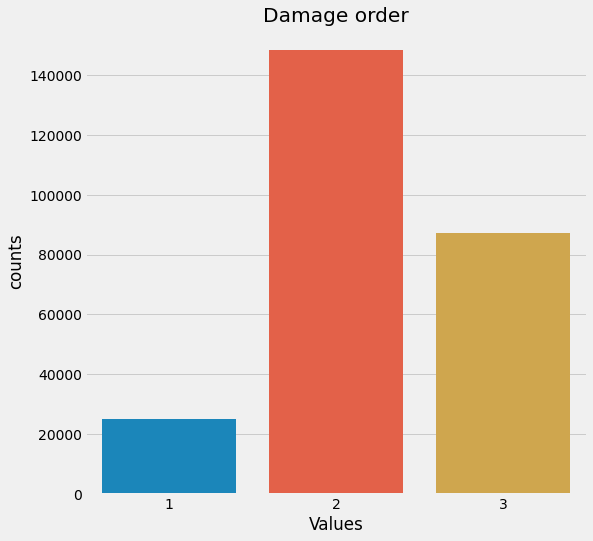

In [ ]:
plt.figure(figsize=(8,8))
plt.style.use('fivethirtyeight')
sns.countplot(train_labels['damage_grade'])
plt.xlabel('Values'); plt.ylabel('counts'); 
plt.title('Damage grade')

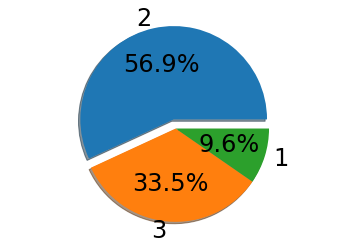

In [ ]:
percent = list(train['damage_grade'].value_counts()/len(train['damage_grade'])*100)
label = list(train['damage_grade'].value_counts().index)
explode = (0.1,0,0)
fig,ax1 = plt.subplots()
ax1.pie(percent, explode=explode, labels=label, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.show()

Damage category 2 & 3 are higher than 1

### Density plot on continuous value features

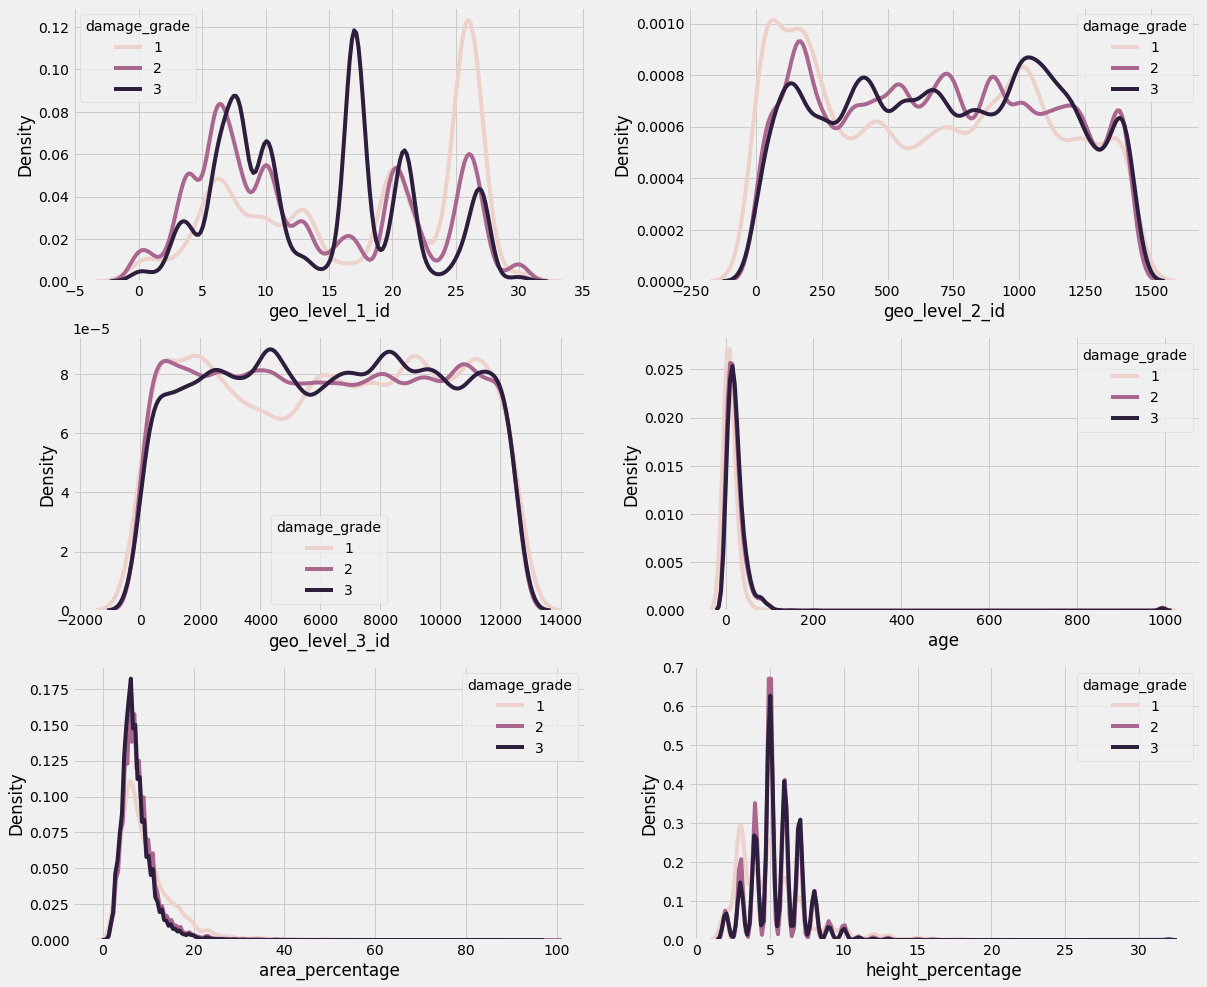

In [ ]:
#continuous values
cont_values = ['geo_level_1_id','geo_level_2_id','geo_level_3_id','age','area_percentage','height_percentage']

def densityPlot(cont_values):
  fig = plt.figure(figsize=(18,16))
  plt.style.use('fivethirtyeight')
  for i,txt in enumerate(cont_values):
    ax = fig.add_subplot(3,2,i+1)
    sns.kdeplot(train.loc[train['damage_grade'] == 1, txt], ax=ax, hue=train['damage_grade'])
    sns.kdeplot(train.loc[train['damage_grade'] == 2, txt], ax=ax, hue=train['damage_grade'])
    sns.kdeplot(train.loc[train['damage_grade'] == 3, txt], ax=ax, hue=train['damage_grade'])
  plt.show()
densityPlot(cont_values)

From plotting continuous feature values using kdeplot (kernel density plot), we can see there is few changes in pattern on columns `geo_level_1_id`,`geo_level_2_id` which will help us for better prediction

### Count plot on binary features

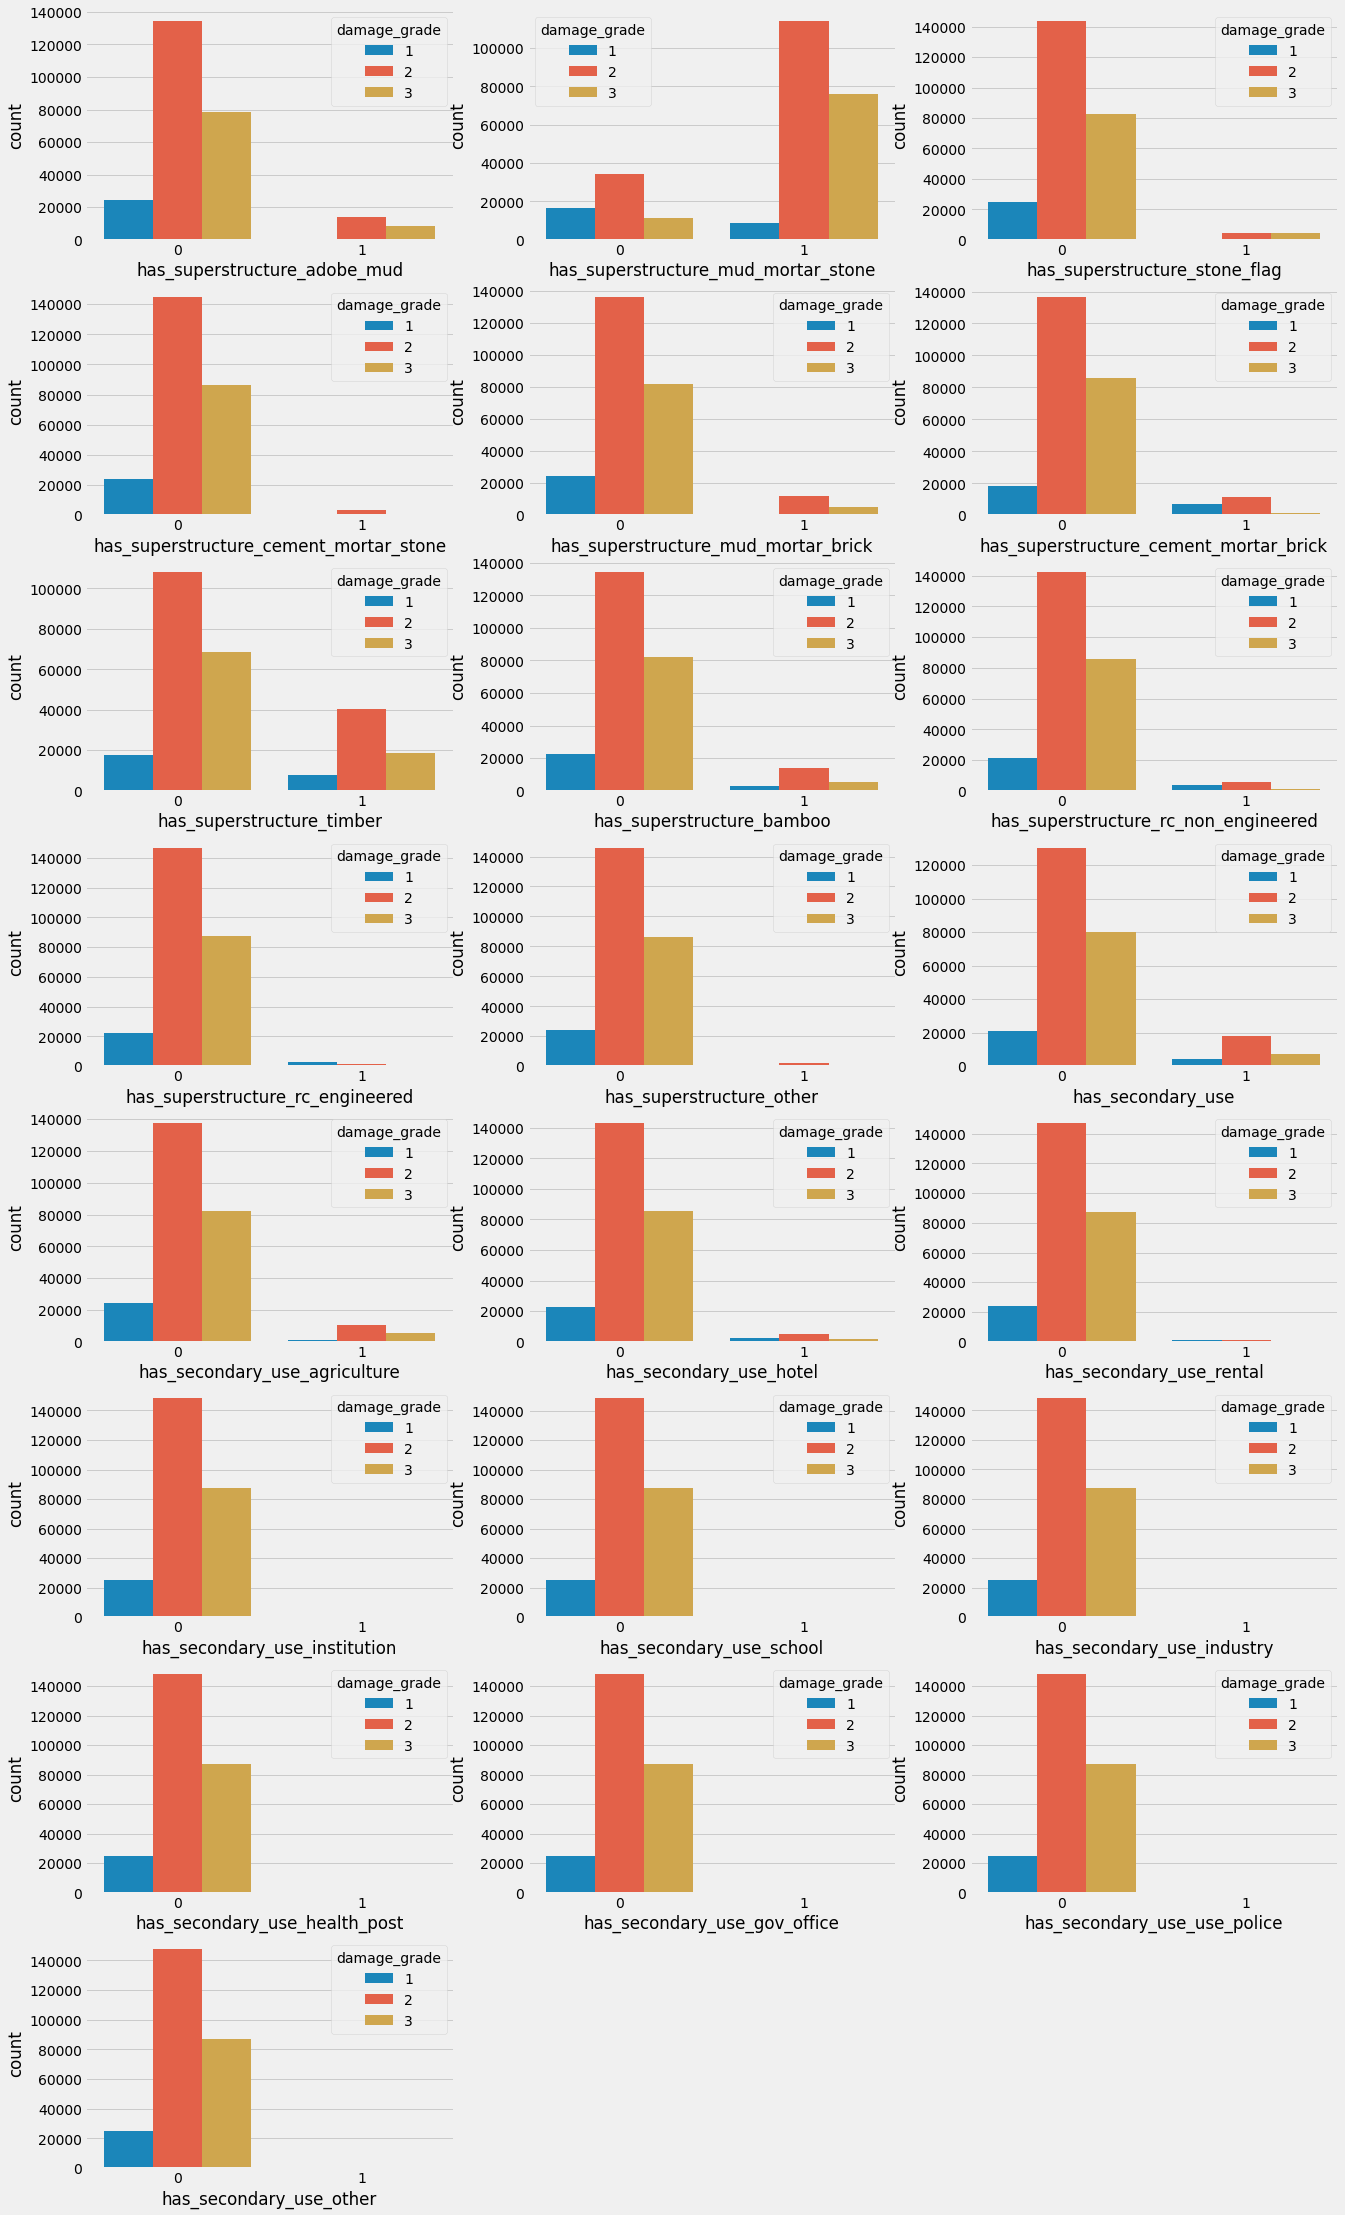

In [ ]:
#Binary columns are selected using the column name having word 'has'
bin_cols = train.columns[train.columns.str.startswith('has')]

def countPlot(bin_cols):
  plt.rcParams['font.size'] = 18
  plt.style.use('fivethirtyeight')
  fig = plt.figure(figsize=(20,37))
  for i,txt in enumerate(bin_cols):
    ax = fig.add_subplot(8,3,i+1)
    sns.countplot(x=train[txt], ax=ax, hue=train['damage_grade'])
  plt.show()
countPlot(bin_cols)

1. All binary columns have more zero than 1, except `has_superstructure_cement_mortar_stone`
2. In some columns there seems having only single value like all 0's, need to check.

### Count plot on categorical columns

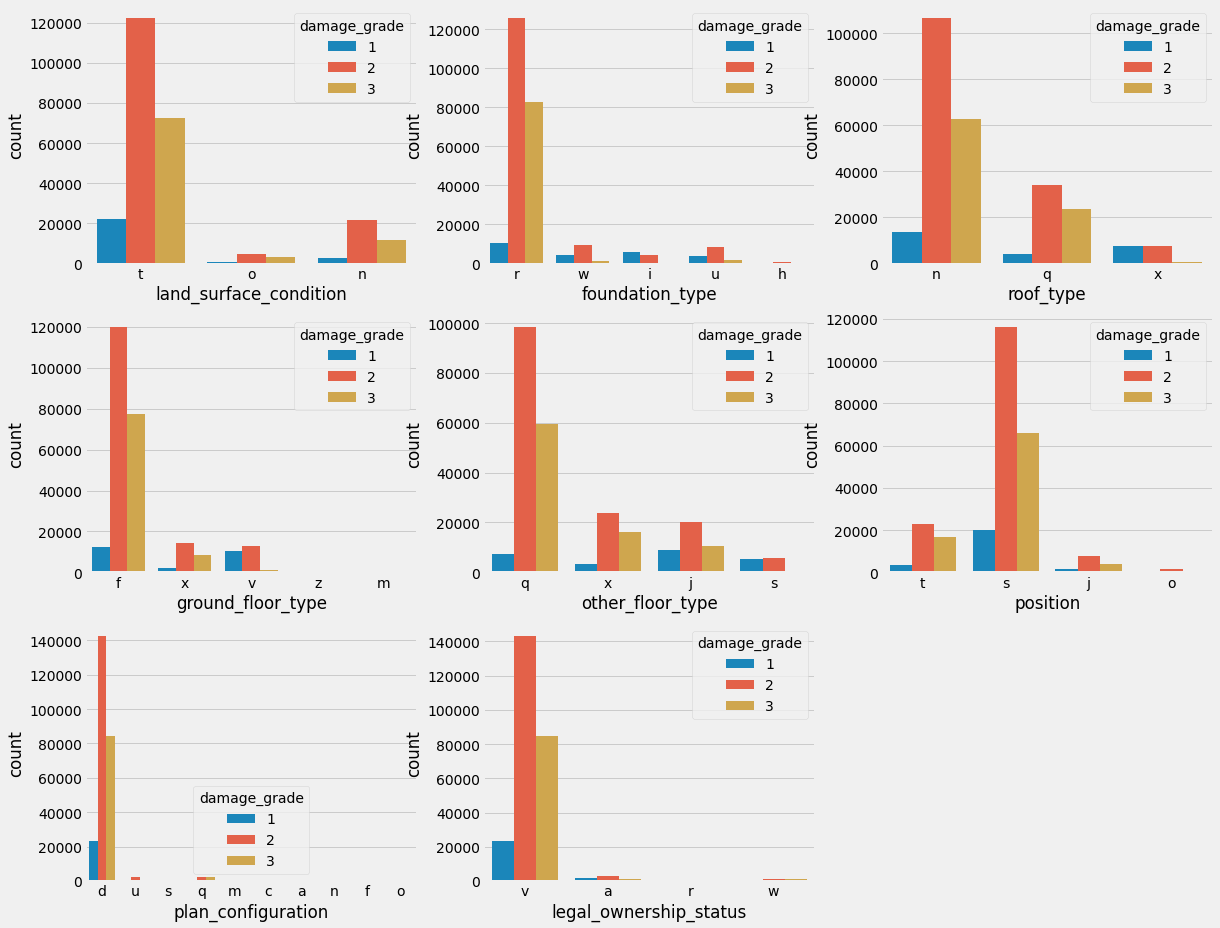

In [ ]:
cat_cols = train.select_dtypes(include=np.object).columns

def catPlot(cat_cols):
  plt.rcParams['font.size'] = 18
  plt.style.use('fivethirtyeight')
  fig = plt.figure(figsize=(18,15))
  for i,txt in enumerate(cat_cols):
    ax = fig.add_subplot(3,3,i+1)
    sns.countplot(x=train[txt], ax=ax, hue=train['damage_grade'])
  plt.show()
catPlot(cat_cols)

### Feature engineering

As a first step we need to concat both train & test data to do feature engineering on both the data.

In [ ]:
df_full = pd.concat([train, test_values], axis=0).reset_index(drop=True)
df_full.shape

(347469, 40)

Function to merge new columns generated through feature engineering

In [ ]:
def merge_by_concat(df1, df2, merge_on):
  merged_gf = df1[merge_on]
  merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
  new_columns = [col for col in list(merged_gf) if col not in merge_on]
  df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
  return df1

Now let us create new columns by grouping *geographical* columns.
1. Creating mean `age`,`height_percentage`,`area_percentage` from grouping geographic level columns `geo_level_1_id`,`geo_level_2_id`,`geo_level_3_id`

In [ ]:
geo_age_mean = df_full.groupby(['geo_level_1_id','geo_level_2_id','geo_level_3_id'])['age'].agg(['mean']).reset_index().rename(columns={'mean':'geo_grp_age_mean'})
geo_height_mean = df_full.groupby(['geo_level_1_id','geo_level_2_id','geo_level_3_id'])['height_percentage'].agg(['mean']).reset_index().rename(columns={'mean':'geo_grp_height_mean'})
geo_area_mean = df_full.groupby(['geo_level_1_id','geo_level_2_id','geo_level_3_id'])['area_percentage'].agg(['mean']).reset_index().rename(columns={'mean':'geo_grp_area_mean'})

Now let us create new columns by grouping different types of *roof* columns

2. Creating mean `age`,`height_percentage`,`area_percentage` from grouping roof & foundation columns `foundation_type`,`roof_type`,`ground_floor_type`,`other_floor_type'

In [ ]:
type_age_mean = df_full.groupby(['foundation_type','roof_type','ground_floor_type','other_floor_type'])['age'].agg(['mean']).reset_index().rename(columns={'mean':'type_grp_age_mean'})
type_height_mean = df_full.groupby(['foundation_type','roof_type','ground_floor_type','other_floor_type'])['height_percentage'].agg(['mean']).reset_index().rename(columns={'mean':'type_grp_height_mean'})
type_area_mean = df_full.groupby(['foundation_type','roof_type','ground_floor_type','other_floor_type'])['area_percentage'].agg(['mean']).reset_index().rename(columns={'mean':'type_grp_area_mean'})

In [ ]:
#Merge the newly created columns
df_full = merge_by_concat(df_full, geo_age_mean, ['geo_level_1_id','geo_level_2_id','geo_level_3_id'])
df_full = merge_by_concat(df_full, geo_height_mean, ['geo_level_1_id','geo_level_2_id','geo_level_3_id'])
df_full = merge_by_concat(df_full, geo_area_mean, ['geo_level_1_id','geo_level_2_id','geo_level_3_id'])

df_full = merge_by_concat(df_full, type_age_mean, ['foundation_type','roof_type','ground_floor_type','other_floor_type'])
df_full = merge_by_concat(df_full, type_height_mean, ['foundation_type','roof_type','ground_floor_type','other_floor_type'])
df_full = merge_by_concat(df_full, type_area_mean, ['foundation_type','roof_type','ground_floor_type','other_floor_type'])

Let us check whether binary columns having only single values, because they will not help for model creation

In [ ]:
colname=[]
val=[]
bin_cols = df_full.columns[df_full.columns.str.contains('has')]
for bcol in bin_cols:
  colname.append(bcol)
  val.append(df_full[bcol].value_counts().sort_index().values)
pd.DataFrame(val, index=colname)

,0,1
has_superstructure_adobe_mud,316554,30915
has_superstructure_mud_mortar_stone,82671,264798
has_superstructure_stone_flag,335528,11941
has_superstructure_cement_mortar_stone,341104,6365
has_superstructure_mud_mortar_brick,323848,23621
has_superstructure_cement_mortar_brick,321440,26029
has_superstructure_timber,258995,88474
has_superstructure_bamboo,318046,29423
has_superstructure_rc_non_engineered,332678,14791
has_superstructure_rc_engineered,341964,5505


Our assumption is wrong there is no column with single values, all binary column having both 0 & 1.

Now let us create new column with frequency encoding technique for categorical columns as a process in feature engineering

In [ ]:
freq_cols = ['land_surface_condition','foundation_type','roof_type',
             'ground_floor_type','other_floor_type','position','plan_configuration',
             'legal_ownership_status']

def frequency_encode(cols, df, self_encoding=False):
  for c in cols:
    fq_dict = df[c].value_counts().to_dict()
    if self_encoding:
      df[c] = df[c].map(fq_dict)
    else:
      df[c+'fq_enc'] = df[c].map(fq_dict)
  return df
df_full_freq = frequency_encode(freq_cols, df_full, self_encoding=True)

We have finished feature engineering, as a next step we may split the train & test data for further process

In [ ]:
train_new = df_full_freq[:train_values.shape[0]]
test_new = df_full_freq[train_values.shape[0]:]

As a final step we need to check whether columns in our training data have any collinearity between them

In [ ]:
corr_matrix = train_new.drop(columns=['building_id','damage_grade'], axis=1).corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]
print('Number of columns having collinearity with other columns other than target: ', len(to_drop))

Number of columns having collinearity with other columns other than target:  0


## Scaling data

We will scale all columns to avoid unwanted weightage for columns based on different range of numeric values like binary columns will have only 0 & 1, but geographic column having numeric values > 4 digits. 

In [ ]:
scaler = StandardScaler()

features = train_new.drop(columns=['building_id','damage_grade'], axis=1).columns

X = train_new.drop(columns=['building_id','damage_grade'], axis=1)
test_new = test_new.drop(columns=['building_id','damage_grade'], axis=1)

y = train_new['damage_grade']

sc = scaler.fit(X)
temp_train_X = sc.transform(X)
test_scaled = sc.transform(test_new)

X = pd.DataFrame(temp_train_X, columns=features)
test = pd.DataFrame(test_scaled, columns=features)

# Model creation

### Function to check f1 score of model

In [ ]:
def check_model_f1_score(model):
  model.fit(X_train, y_train)
  test_y_pred = model.predict(X_test)
  return f1_score(y_test, test_y_pred, average='micro')

Spliting train data as 75% as train & remaining as test data for validating our model.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Let us create a base prediction, by guessing damage grade value.
Here we may do value_counts and select the grade with most value counts as the guessing damage grade prediction value.
Using that value let us check base prediction to check our trained model score need to cross more than the base model.

In [ ]:
grade_guess = y_test.value_counts().index[0]
base_prediction = np.full(np.shape(y_test), grade_guess)
print('F1 score of base prediction with guess value: ',f1_score(y_test, base_prediction, average='micro'))

0.5680919916603778

In [ ]:
lr = LogisticRegression(multi_class='multinomial')
lr_score = check_model_f1_score(lr)
print('Basic LOGISTIC REGRESSION model with default params: ', lr_score)

Basic LOGISTIC REGRESSION model with default params:  0.5914096775431371


Out initial logistic model have crossed the base model score, so we can proceed further to try different types of model like ensemble for better score.

In [ ]:
dc = DecisionTreeClassifier()
dc_score = check_model_f1_score(dc)
print('DECISION CLASSIFIER model with default params: ', dc_score)

DECISION CLASSIFIER model with default params:  0.6639848556554662


In [ ]:
rc = RandomForestClassifier()
rc_score = check_model_f1_score(rc)
print('Basic RANDOM FOREST model with default params: ', rc_score)

Basic RANDOM FOREST model with default params:  0.7243064171601796


In [ ]:
knc = KNeighborsClassifier()
knc_score = check_model_f1_score(knc)
print('KNEIGHBORS model with default params: ', knc_score)

KNEIGHBORS model with default params:  0.6593417838093655


In [ ]:
xg = xgb.XGBClassifier()
xg_score = check_model_f1_score(xg)
print('XGB model with default params: ', xg_score)

XGB model with default params:  0.677095457975723


<Figure size 576x432 with 0 Axes>

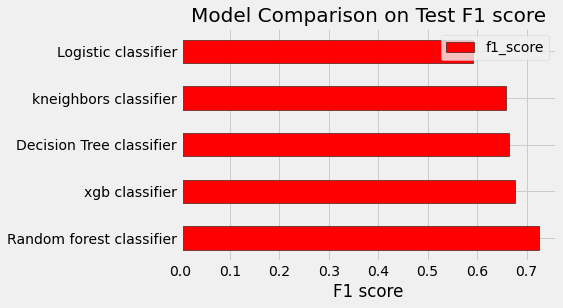

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,6))
model_comparison = pd.DataFrame({'model':['Logistic classifier','Decision Tree classifier',
                       'Random forest classifier', 'kneighbors classifier',
                       'xgb classifier'], 'f1_score':[lr_score,dc_score,rc_score,
                                                      knc_score,xg_score]})

# Horizontal bar chart of test mae
model_comparison.sort_values('f1_score', ascending = False).plot(x = 'model', y = 'f1_score', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('F1 score'); plt.xticks(size = 14)
plt.title('Model Comparison on Test F1 score', size = 20);

On seeing the model comparison plot, it is clear that *Random foreset classsifier* out performs than other models, so let us proceed to fine tune hyper parameter of the model further for analysis.

# Random Search with default Cross Validation

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 400, num = 3)]

# specify parameters and distributions to sample from
param_dist = {'n_estimators': n_estimators,
              "max_depth": [3, None],
              "max_features": [1,3,10],
              "min_samples_split": [1,3,10],
              "min_samples_leaf": [1,3,10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

rc = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(rc, param_distributions=param_dist)

# Fit the random search model
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [ ]:
random_search.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 400}

In [ ]:
best_random = random_search.best_estimator_
best_random_score = check_model_f1_score(best_random)
print('RANDOM SEARCH model with tuned params: ', best_random_score)

`RANDOM SEARCH model with tuned params: 0.7405379823742342`

# Grid Search CV

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'criterion': ["entropy"],
    'max_depth': [4,5,None],
    'max_features': [10,12,14],
    'n_estimators': [400, 500, 600]
}

In [ ]:
# Create a based model
rc = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rc, param_grid = param_grid, 
                           scoring = 'f1_micro', n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

In [ ]:
#best params
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_
best_grid_score = check_model_f1_score(best_grid)
print('GRID SEARCH model with tuned params: ', best_grid_score)

In [ ]:
best_params = {
    'bootstrap': False,
    'criterion': 'entropy',
    'max_depth': None,
    'max_features': 10,
    'n_estimators': 500
    }

rc = RandomForestClassifier(n_estimators=500, bootstrap=False, criterion='entropy',max_depth=None,
                            max_features=10, random_state=42)

rc_score = check_model_f1_score(rc)
print('RANDOM FOREST model with fine tuned params: ', rc_score)

RANDOM FOREST model with fine tuned params:  0.7149946918049143


Fine tuned params for Random forest not improved, so let us use other model for prediction.

In [ ]:
clf = xgb.XGBClassifier(
    n_estimators=2000,
    objective='multi:softmax',
    num_class=3,
    max_depth=12, 
    learning_rate=0.02, 
    subsample=0.8,
    colsample_bytree=0.4, 
    missing=-1, 
    eval_metric='mlogloss',
    nthread=4,
    tree_method='hist'     
    )

In [ ]:
clf.fit(X_train, y_train, eval_set=[(X_test,y_test)],verbose=50, early_stopping_rounds=100)

[0]	validation_0-mlogloss:1.08984
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[50]	validation_0-mlogloss:0.812838
[100]	validation_0-mlogloss:0.702677
[150]	validation_0-mlogloss:0.648334
[200]	validation_0-mlogloss:0.620689
[250]	validation_0-mlogloss:0.60311
[300]	validation_0-mlogloss:0.592099
[350]	validation_0-mlogloss:0.584504
[400]	validation_0-mlogloss:0.579373
[450]	validation_0-mlogloss:0.575092
[500]	validation_0-mlogloss:0.572132
[550]	validation_0-mlogloss:0.569627
[600]	validation_0-mlogloss:0.568129
[650]	validation_0-mlogloss:0.566654
[700]	validation_0-mlogloss:0.565732
[750]	validation_0-mlogloss:0.564966
[800]	validation_0-mlogloss:0.56448
[850]	validation_0-mlogloss:0.564282
[900]	validation_0-mlogloss:0.564182
[950]	validation_0-mlogloss:0.564059
[1000]	validation_0-mlogloss:0.564093
[1050]	validation_0-mlogloss:0.564318
Stopping. Best iteration:
[965]	validation_0-mlogloss:0.564019



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, eval_metric='mlogloss',
              gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=-1, n_estimators=2000, n_jobs=1,
              nthread=4, num_class=3, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.8, tree_method='hist',
              verbosity=1)

In [ ]:
#train_y_pred = clf.predict(X_train)
test_y_pred = clf.predict(X_test)

In [ ]:
f1_score(y_train, train_y_pred, average='micro')
f1_score(y_test, test_y_pred, average='micro')

0.7495555186042644

In [ ]:
def save_prediction(model, csv_name):
  build_id = test_values['building_id']
  final_prediction = model.predict(test)
  final_prediction = final_prediction.astype(np.int64)
  output_path = os.path.join(root_path, csv_name)
  pd.DataFrame({'building_id':build_id, 'damage_grade':final_prediction}).to_csv(output_path, index=False)